In [1]:
import os
import time
from copy import copy
from pathlib import Path
from joblib import Memory
from scipy import sparse
from scipy.sparse import csc_matrix
from scipy.special import expit
from scipy.stats import pearsonr
import scikitplot as skplt
import shap

from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample, shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, normalize
from sklearn import metrics
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

from xgboost import XGBClassifier
from category_encoders import TargetEncoder

import pyarrow.feather as feather
import matplotlib.pyplot as plt
import plotnine as p9
import pandas as pd
import numpy as np

rand_state = 5991

# Paths
my_filesys_pth = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/"

idcsc = my_filesys_pth + "data/created_subsets/id_csc.feather"
tarcsc = my_filesys_pth + "data/created_subsets/tarcsc.feather"
fulldf = my_filesys_pth + "data/created_subsets/full_df.feather"

### Functions

In [2]:
def split_data(xx, yy, testsize = 1000):
    xtrain, xtest, y_train, y_test = train_test_split(xx,
                                                      yy,
                                                      test_size = testsize,
                                                      random_state = rand_state)
    xtrain, xvalid, y_train, y_valid = train_test_split(xtrain, y_train, 
                                                        test_size = testsize,
                                                        random_state = rand_state)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    y_valid = np.array(y_valid).reshape(-1, 1)

    print(" SHAPE of xtrain:", xtrain.shape)
    print("SHAPE of y_train:", y_train.shape)
    print("  SHAPE of xtest:", xtest.shape)
    print(" SHAPE of y_test:", y_test.shape)
    print(" SHAPE of xvalid:", xvalid.shape)
    print("SHAPE of y_valid:", y_valid.shape)

    return xtrain, y_train, xtest, y_test, xvalid, y_valid 

def get_acc_auc(y, p):
    acc = np.sum(y == p) / len(y)
    auc = roc_auc_score(y, p)
    return acc, auc

def get_outs(model, train, test, valid, ytrain, ytest, yvalid):
    train_acc = round(model.score(train, ytrain), 4)
    test_acc = round(model.score(test, ytest), 4)
    valid_acc = round(model.score(valid, yvalid), 4)

    train_auc = round(roc_auc_score(ytrain, model.predict_proba(train)[:,1]), 4)
    test_auc = round(roc_auc_score(ytest, model.predict_proba(test)[:,1]), 4)
    valid_auc = round(roc_auc_score(yvalid, model.predict_proba(valid)[:,1]), 4)

    return train_auc, test_auc, valid_auc, train_acc, test_acc, valid_acc  

### Data import and double check missing values

In [3]:
id_csc = feather.read_feather(idcsc)
tar_csc = feather.read_feather(tarcsc)
full_df = feather.read_feather(fulldf)

missing = pd.DataFrame(full_df.isna().sum())
missing.reset_index(inplace=True)
missing[missing[0] > 0]


,index,0


col_0,PELLCAT
PELLCAT,
0.0,3463
1.0,2416


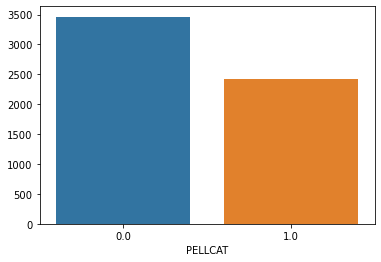

In [82]:
df = pd.DataFrame(tar_csc.PELLCAT, columns = ["PELLCAT"])
df1 = pd.crosstab(df["PELLCAT"], columns = ["PELLCAT"])

sns.barplot(data = df1.T)
df1

### Look at target values and grab KSU's data

In [4]:
df1 = id_csc.query("INSTNM == 'Kennesaw State University'")
df1["UNITID"] = "486840"

df2 = full_df.iloc[5587:5588]
df2["UNITID"] = "486840"

KSU_data = pd.merge(df1, df2, how = "left",
         left_on = "UNITID", right_on = "UNITID")

tar_csc


C:\Users\Nate\AppData\Local\Temp/ipykernel_2852/3630896342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Nate\AppData\Local\Temp/ipykernel_2852/3630896342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ids,UNITID,PELLCAT
0,0,100654.0,1.0
1,1,100663.0,0.0
2,2,100690.0,1.0
3,3,100706.0,0.0
4,4,100724.0,1.0
...,...,...,...
5874,5874,493080.0,0.0
5875,5875,493150.0,1.0
5876,5876,493372.0,1.0
5877,5877,493424.0,0.0


### Split data into train, test, and validation datasets & drop problem variables

In [5]:
ys = tar_csc["PELLCAT"].copy()
full_df["ST_FIPS"] = full_df["ST_FIPS"].astype(int)
xs = full_df.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31"], axis = 1).copy()
print("SHAPE of xs:", xs.shape)
print("SHAPE of ys:", ys.shape)
xtrain, y_train, xtest, y_test, xvalid, y_valid = split_data(xs, ys, testsize = 1000)
print(xtrain.shape)

SHAPE of xs: (5879, 315)
SHAPE of ys: (5879,)
 SHAPE of xtrain: (3879, 315)
SHAPE of y_train: (3879, 1)
  SHAPE of xtest: (1000, 315)
 SHAPE of y_test: (1000, 1)
 SHAPE of xvalid: (1000, 315)
SHAPE of y_valid: (1000, 1)
(3879, 315)


In [6]:
xnot =  list(xtrain.columns[xtrain.columns.str.startswith("PELL")])
print("variables to be removed:")
print(len(xnot))
print("remaining variables:")

features = xtrain.columns
features2 = xtrain.columns.drop(xnot)

print(len(features2))

variables to be removed:
2
remaining variables:
313


### Feature Scaling
##### Creation of the standardized dataset & the standardized-transformed dataset

In [7]:
scaler = StandardScaler()
poly = PolynomialFeatures(3)

scaler.fit(xtrain[features])
xtrain2 = pd.DataFrame(scaler.transform(xtrain[features]), columns = features)
xvalid2 = pd.DataFrame(scaler.transform(xvalid[features]), columns = features)
xtest2 = pd.DataFrame(scaler.transform(xtest[features]), columns = features)

scaler.fit(xtrain[features2])
xtrain3 = pd.DataFrame(scaler.transform(xtrain[features2]), columns = features2)
xvalid3 = pd.DataFrame(scaler.transform(xvalid[features2]), columns = features2)
xtest3 = pd.DataFrame(scaler.transform(xtest[features2]), columns = features2)

print("      ORIGINAL -  xtrain before:", xtrain.shape)
print("        SCALED - xtrain2 before:", xtrain2.shape)
print("SCALED&REDUCED - xtrain3 before:", xtrain3.shape)

      ORIGINAL -  xtrain before: (3879, 315)
        SCALED - xtrain2 before: (3879, 315)
SCALED&REDUCED - xtrain3 before: (3879, 313)


### Checking for correlation between feature pairings

##### Original dataset

In [8]:
corrs = []
contFeat = list(xtrain.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain[contFeat[i]].values.flatten()
        featj = xtrain[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

C:\Users\Nate\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


(3879, 315)
49455  : Total number of features pairs:
2008    : Number of features pairs with absolute Pearson Correl above 0.5:
4.0603 % : Percent of features pairs with absolute Pearson Correl above 0.5:


##### Standardized dataset

In [9]:
corrs = []
contFeat = list(xtrain2.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain2[contFeat[i]].values.flatten()
        featj = xtrain2[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain2.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

(3879, 315)
49455  : Total number of features pairs:
2008    : Number of features pairs with absolute Pearson Correl above 0.5:
4.0603 % : Percent of features pairs with absolute Pearson Correl above 0.5:


##### Standardized and transformed dataset (before variable tranformation)

In [10]:
# SCALED AND REDUCED DATASET
corrs = []
contFeat = list(xtrain3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain3[contFeat[i]].values.flatten()
        featj = xtrain3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

(3879, 313)
48828  : Total number of features pairs:
1934    : Number of features pairs with absolute Pearson Correl above 0.5:
3.9608 % : Percent of features pairs with absolute Pearson Correl above 0.5:


### Feature Transformation

In [11]:
# CREDIT: Dr. Vanderheyden wrote this code.
# During my study of Dr. Vanderheydens code below I created
# The get_acc_auc function and decided that the exponential
# and polynomial variables should not be created for this 
# project 
accuracies = []
for f in features2:
    log_reg = LogisticRegression(solver = "saga",
                                 random_state = rand_state,
                                 penalty = "l1",
                                 class_weight = "balanced",
                                 max_iter = 1000)
    x = xtrain3[f].values.reshape(-1, 1)
    y = y_train.reshape(-1, 1)
    ## LIN ##############################
    log_reg.fit(x, y)
    acc, auc = get_acc_auc(y, log_reg.predict(x))
    ## LOG #############################   
    xl = np.log(x - np.min(x) + 1)
    log_reg.fit(xl, y)
    lcc, luc = get_acc_auc(y, log_reg.predict(xl))

    if lcc / acc >= 1.1 or luc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_log"] = xl
        xvalid3[f + "_log"] = np.log(xvalid3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
        xtest3[f + "_log"] = np.log(xtest3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
    ## EXP #############################   
    xe = np.exp(x)
    log_reg.fit(xe, y)
    ecc, euc = get_acc_auc(y, log_reg.predict(xe))

    # if ecc / acc >= 1.1 or euc / auc >= 1.05: 
    #     xtrain3[f + "_exp"] = xe
    #     xvalid3[f + "_exp"] = np.exp(xvalid3[f].values.reshape(-1, 1))
    #     xtest3[f + "_exp"] = np.exp(xtest3[f].values.reshape(-1, 1))
    ## POLY ############################# 
    poly.fit(x)
    xp = poly.transform(x)
    log_reg.fit(xp, y)
    pcc, puc = get_acc_auc(y, log_reg.predict(xp))
    # if pcc / acc >= 1.1 or puc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
    #     xtrain3[f + "_p2"] = x**2
    #     xtrain3[f + "_p3"] = x**3
    #     xvalid3[f + "_p2"] = (xvalid3[f].values)**2
    #     xvalid3[f + "_p3"] = (xvalid3[f].values)**3
    #     xtest3[f + "_p2"] = (xtest3[f].values)**2
    #     xtest3[f + "_p3"] = (xtest3[f].values)**3
    ## BIN #############################
    xmin = x.min()
    rnge = x.max() - xmin

    xtrn = 0 + ((x - xmin) > 1 * rnge / 10) + ((x - xmin) > 2 * rnge / 10) + ((x - xmin) > 3 * rnge / 10) + ( # the objects in each
                (x - xmin) > 4 * rnge / 10) + ((x - xmin) > 5 * rnge / 10) + ((x - xmin) > 6 * rnge / 10) + ( # bracket returns true
                (x - xmin) > 7 * rnge / 10) + ((x - xmin) > 8 * rnge / 10) + ((x - xmin) > 9 * rnge / 10)     # or false 
    xval = 0 + ((xvalid3[f] - xmin) > 1 * rnge / 10) + ((xvalid3[f] - xmin) > 2 * rnge / 10) + ((xvalid3[f] - xmin) > 3 * rnge / 10) + (
                (xvalid3[f] - xmin) > 4 * rnge / 10) + ((xvalid3[f] - xmin) > 5 * rnge / 10) + ((xvalid3[f] - xmin) > 6 * rnge / 10) + (
                (xvalid3[f] - xmin) > 7 * rnge / 10) + ((xvalid3[f] - xmin) > 8 * rnge / 10) + ((xvalid3[f] - xmin) > 9 * rnge / 10)
    xtst = 0 + ((xtest3[f] - xmin) > 1 * rnge / 10) + ((xtest3[f] - xmin) > 2 * rnge / 10) + ((xtest3[f] - xmin) > 5 * rnge / 10) + (
                (xtest3[f] - xmin) > 3 * rnge / 10) + ((xtest3[f] - xmin) > 4 * rnge / 10) + ((xtest3[f] - xmin) > 6 * rnge / 10) + (
                (xtest3[f] - xmin) > 7 * rnge / 10) + ((xtest3[f] - xmin) > 8 * rnge / 10) + ((xtest3[f] - xmin) > 9 * rnge / 10)
                
    encoder = TargetEncoder()

    encoder.fit(xtrn, y)
    xb = encoder.transform(xtrn)
    log_reg.fit(xb, y)

    bcc, buc = get_acc_auc(y, log_reg.predict(xb))

    if bcc / acc >= 1.1 or buc / auc >= 1.05: # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_Bin"] = xb
        xvalid3[f + "_Bin"] = encoder.transform(xval)
        xtest3[f + "_Bin"] = encoder.transform(xtst)
    ## COMPLETION #############################
    lDa = lcc / acc
    eDa = ecc / acc
    pDa = pcc / acc
    bDa = bcc / acc
    lda = luc / auc
    eda = euc / auc
    pda = puc / auc
    bda = buc / auc
    accuracies.append([f, acc, lcc, ecc, pcc, bcc, auc, luc, euc, puc, buc, lDa, eDa, pDa, bDa, lda, eda, pda, bda])
###############################################

colums = ["Feature","ACC: Linear", "ACC: Log", "ACC: Exp", "ACC: Poly3","ACC: Bin",
                    "AUC: Simple Linear", "AUC: Log", "AUC: Exp","AUC: Poly3", "AUC: Bin",
                    "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                    "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
accDf = pd.DataFrame(accuracies, columns = colums)

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataCo

In [12]:
print(xtrain3.shape)
# accDf.to_csv("acc_df.csv")
accDf.loc[:, ["Feature", "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                         "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
             ].sort_values("ACC: LOG / Linear", ascending = False).head(5)

(3879, 363)


,Feature,ACC: LOG / Linear,ACC: EXP / Linear,ACC: Poly3 / Linear,ACC: Bin / Linear,AUC: LOG / Linear,AUC: EXP / Linear,AUC: Poly3 / Linear,AUC: Bin / Linear
161,DBRR5_FED_UG_NUM,1.271488,1.352913,0.945048,0.948846,0.954744,0.982190,0.986302,0.969350
192,DBRR10_FED_UG_NUM,1.267631,1.348362,0.941870,0.945654,0.983297,0.994518,0.998682,0.981517
172,DBRR4_FED_UGCOMP_NUM,1.266272,1.348930,0.942266,0.946052,1.027233,1.003707,1.007909,1.001275
270,BBRR2_FED_UGNOCOMP_N,1.263961,1.344124,1.237135,1.335426,0.921907,0.966542,0.915527,0.988048
171,DBRR4_FED_UGCOMP_N,1.229092,1.324280,0.925047,0.934236,1.074429,1.045348,1.049724,1.034776


##### Standardized and transformed dataset (after variable tranformation)

In [13]:
corrs = []
contFeat = list(xtrain3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain3[contFeat[i]].values.flatten()
        featj = xtrain3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

C:\Users\Nate\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


(3879, 363)
65703  : Total number of features pairs:
3116    : Number of features pairs with absolute Pearson Correl above 0.5:
4.7426 % : Percent of features pairs with absolute Pearson Correl above 0.5:


### PCA

#### Original dataset

###### All variables

var    0.99962
dtype: float64
test average log-likelihood:  -inf
validation average log-likelihood:  -inf
train average log-likelihood:  -inf


,0,1
0,LPSTAFFORD_AMT,0.992446
1,LPPPLUS_AMT_y,0.004124
2,DBRR5_FED_UG_NUM,0.002702
3,DBRR1_FED_UG_NUM,0.000348
4,DBRR4_FED_UGUNK_NUM,0.000253


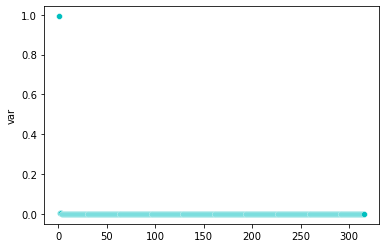

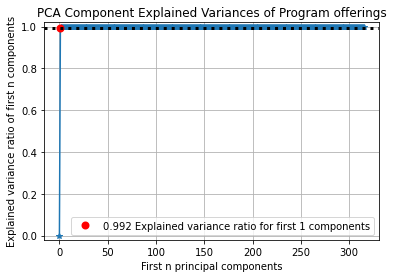

In [14]:
%matplotlib inline

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 5,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:4].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(5) # LPPPLUS_AMT DBRR1_FED_UGCOMP_DEN

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [315] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


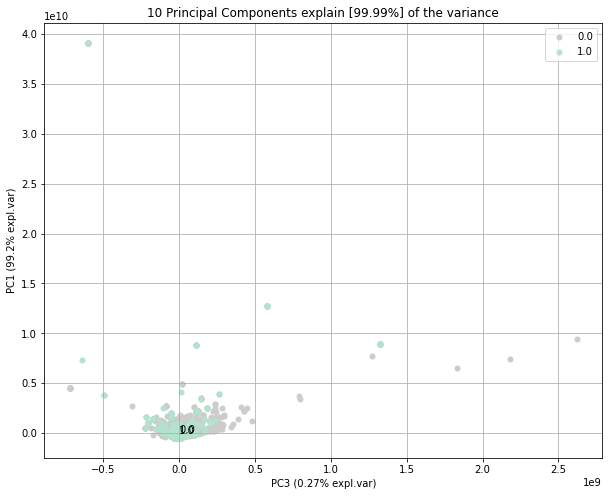

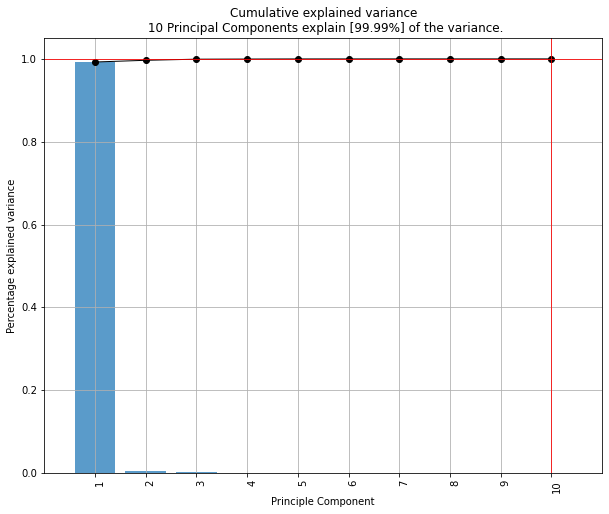

<Figure size 432x288 with 0 Axes>

In [15]:
from pca import pca

model = pca(n_components=10, random_state = rand_state)
results = model.fit_transform(xtrain_var)

model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [2, 0])
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_featureimportance.png')

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


var    1.0
dtype: float64
test average log-likelihood:  -44.98567162138133
validation average log-likelihood:  -44.78185767926248
train average log-likelihood:  -45.066046812638476


,0,1
0,DBRR4_FED_UGUNK_DEN,1.0
1,TUITIONFEE_IN,0.0
2,GRAD_DEBT_MDN,0.0
3,TUITIONFEE_OUT,0.0
4,PCTFLOAN,0.0
5,DBRR10_FED_UG_RT,0.0
6,ACCREDAGENCY Encoded,0.0
7,DBRR4_FED_UGUNK_RT,0.0
8,DBRR4_FED_UGUNK_RT,0.0
9,BBRR2_FED_UG_FBR,0.0


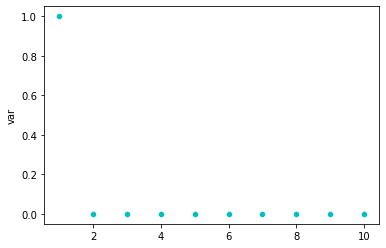

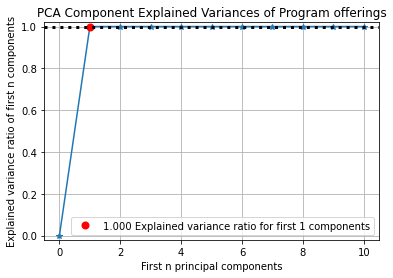

In [16]:
ddrp_lst = ['GRAD_DEBT_MDN10YR',"NOPELL_DEBT_N", 'FTFTPCTFLOAN']

mutual_info = mutual_info_classif(xtrain.drop(ddrp_lst, axis = 1), y_train, random_state = rand_state)
sel_cols = SelectKBest(mutual_info_classif, k = 10)
sel_cols.fit(xtrain.drop(ddrp_lst, axis = 1), y_train)

lst = sel_cols.get_support()
lst = xtrain.drop(ddrp_lst, axis = 1).columns[lst]

x_train = xtrain[lst]
x_test = xtest[lst]
x_valid = xvalid[lst]

x_t1_lst = lst.copy()

%matplotlib inline

xtrain_var = x_train
xtest_var = x_test
xvalid_var = x_valid

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 5,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:4].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_explainedvar.png')

interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10) # LPPPLUS_AMT DBRR1_FED_UGCOMP_DEN

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


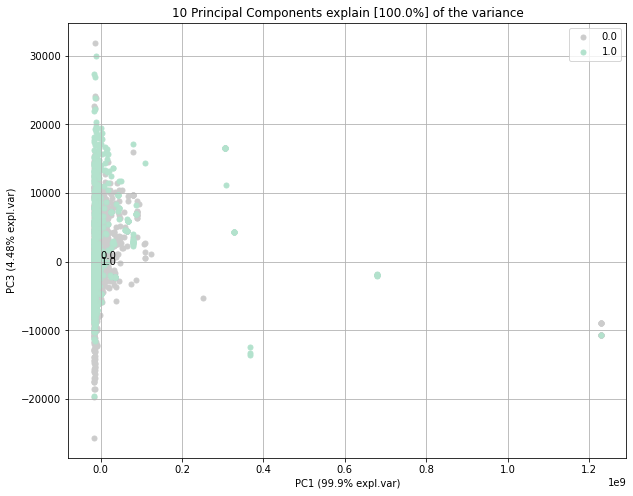

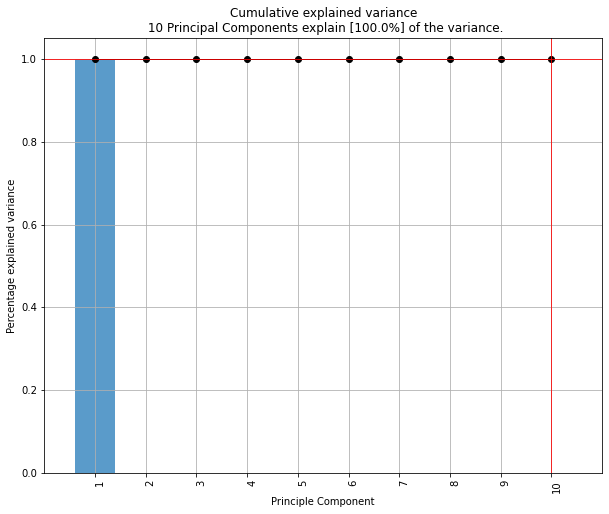

<Figure size 432x288 with 0 Axes>

In [17]:
from pca import pca
model = pca(n_components=10, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 2])
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_featureimportance.png')

#### Standardized dataset

###### All variables

var    0.32234
dtype: float64
test average log-likelihood:  -inf
validation average log-likelihood:  -inf
train average log-likelihood:  -inf


,0,1
0,DBRR1_FED_UG_DEN,0.158873
1,TUITIONFEE_OUT,0.108523
2,ACCREDAGENCY Encoded,0.054944
3,BBRR2_FED_UGCOMP_NOPROG,0.043062
4,DBRR1_PP_UG_N,0.035594
5,OMENRAP_FULLTIME_y,0.024793
6,OMACHT6_FTFT,0.021476
7,NUM4_PRIV,0.01653
8,CCBASIC_33,0.013572
9,OMENRYP_FULLTIME_y,0.012778


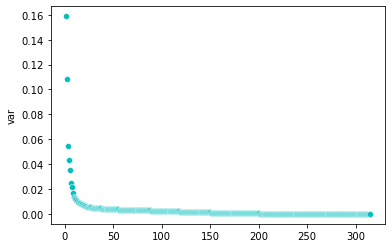

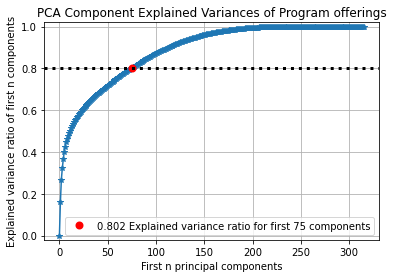

In [18]:
file_specific_pth = "images/STAND/FULL/PCA/"

x_train2 = xtrain2
x_test2 = xtest2
x_valid2 = xvalid2

%matplotlib inline

xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 80,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [315] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[80]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


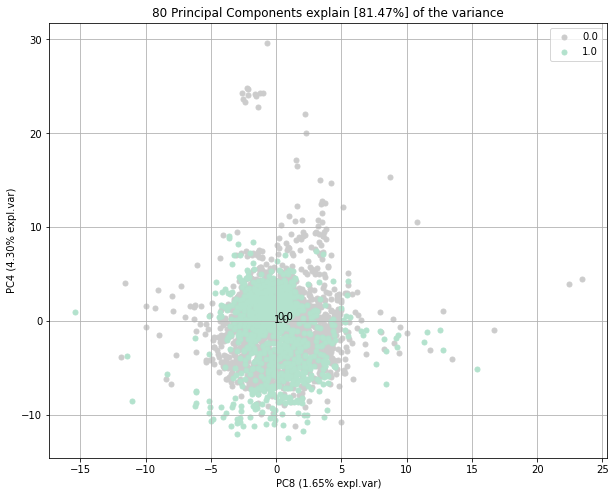

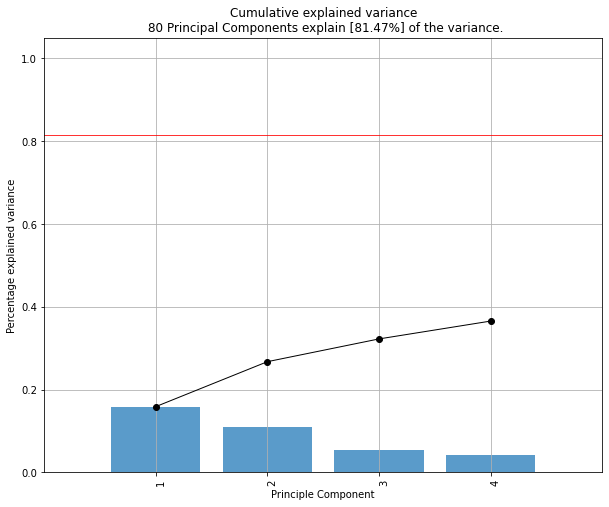

<Figure size 432x288 with 0 Axes>

In [19]:
from pca import pca

model = pca(n_components=80, random_state = rand_state)
results = model.fit_transform(xtrain_var)
# model.biplot(y = y_train.reshape(-1,), n_feat=3, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [7, 3])#np.arange(0,k,1)) 7 2
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=4) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


var    0.746036
dtype: float64
test average log-likelihood:  -10.834475092988516
validation average log-likelihood:  -10.620290890723147
train average log-likelihood:  -10.816847461093346


,0,1
0,MALE_DEBT_MDN,0.426789
1,PCTFLOAN,0.181382
2,DBRR4_FED_UGUNK_DEN,0.137865
3,DBRR4_FED_UGUNK_DEN,0.076832
4,PCTFLOAN,0.062063
5,ACCREDAGENCY Encoded,0.048386
6,WDRAW_DEBT_MDN,0.025513
7,BBRR2_FED_UG_FBR,0.018602
8,GRAD_DEBT_MDN,0.016447
9,TUITIONFEE_OUT,0.006122


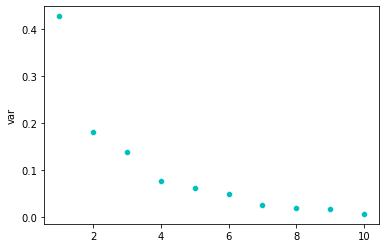

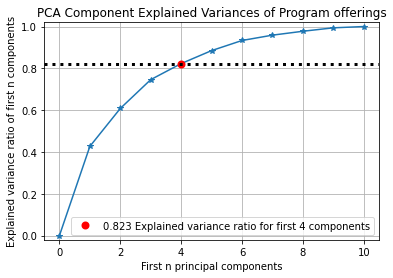

In [20]:
file_specific_pth = "images/STAND/REDUC/PCA/"

mutual_info = mutual_info_classif(xtrain2.drop("GRAD_DEBT_MDN", axis = 1), y_train, random_state = rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain2, y_train)
lst = sel_five_cols.get_support()
lst = xtrain2.columns[lst]
x_train2 = xtrain2[lst]
x_test2 = xtest2[lst]
x_valid2 = xvalid2[lst]

x_t2_lst = lst.copy()

%matplotlib inline

xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 10,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


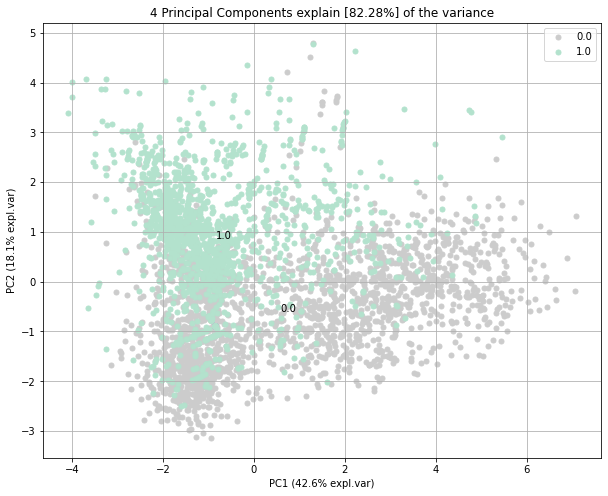

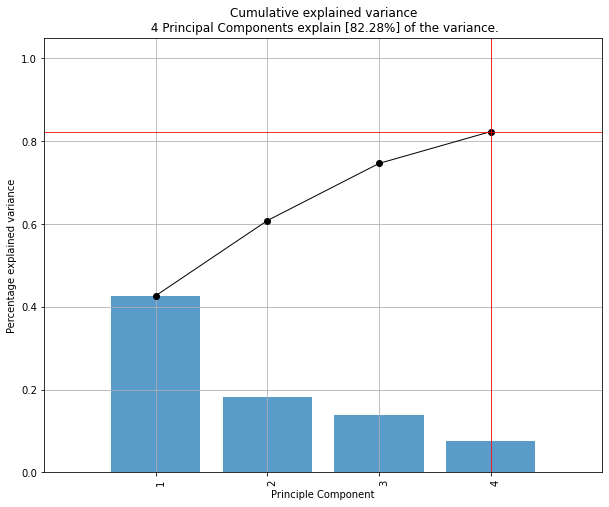

<Figure size 432x288 with 0 Axes>

In [21]:
from pca import pca

model = pca(n_components=4, random_state = rand_state)
results = model.fit_transform(xtrain_var)
# model.biplot(y = y_train.reshape(-1,), n_feat=3, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 1])#np.arange(0,k,1)) 7 2
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=4) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

#### Standardized-Transformed dataset

###### All variables

var    0.339621
dtype: float64
test average log-likelihood:  -1.8952372177162898e+27
validation average log-likelihood:  -1.8952372177209701e+27
train average log-likelihood:  756.4511266264627


,0,1
0,DBRR1_FED_UGCOMP_DEN_x,0.148034
1,OMAWDP8_FIRSTTIME_Bin,0.134533
2,ACCREDAGENCY Encoded,0.057053
3,BBRR2_FED_UGCOMP_NOPROG,0.043716
4,DBRR1_PP_UG_N,0.03435
5,OMENRAP_FULLTIME_x,0.026291
6,OMENRUP8_FTNFT_Bin,0.022897
7,NUM4_PRIV,0.016383
8,OMENRUP8_FTNFT_Bin,0.015856
9,CCUGPROF_5,0.012419


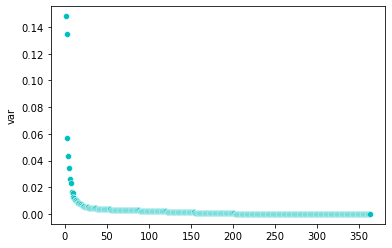

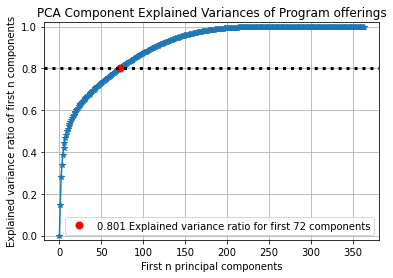

In [22]:
file_specific_pth = "images/STAND_TRAN/FULL/PCA/"
# drrp = ["CCBASIC_31_exp", "CCUGPROF_8_exp", "OMENRYP_FULLTIME_exp", "OMACHT8_FTFT_exp", "OPEFLAG_3_exp", "CCBASIC_25_exp", "CCUGPROF_0_exp", "INEXPFTE_exp"]
%matplotlib inline

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 80,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [363] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[80]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


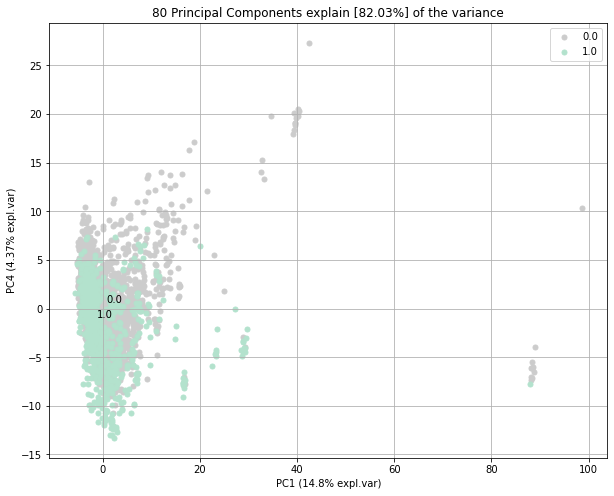

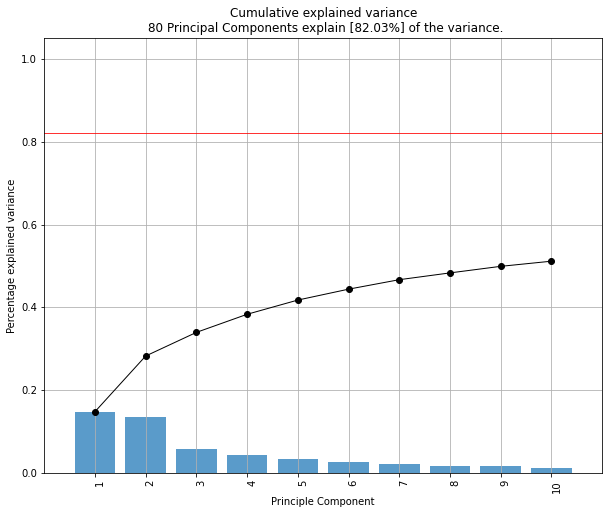

<Figure size 432x288 with 0 Axes>

In [23]:
from pca import pca

model = pca(n_components=80, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 3])
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(3879, 10)
var    0.636603
dtype: float64
test average log-likelihood:  -10.420918912521
validation average log-likelihood:  -10.41077322001008
train average log-likelihood:  -10.549246681119602


,0,1
0,BBRR2_FED_UG_FBR,0.434575
1,PCTFLOAN,0.202028
2,ACCREDAGENCY Encoded,0.14821
3,PCTFLOAN,0.064888
4,WDRAW_DEBT_MDN,0.044858
5,ACCREDAGENCY Encoded,0.040466
6,GRAD_DEBT_MDN10YR,0.023228
7,BBRR2_FED_UG_FBR,0.019436
8,BBRR2_FED_UG_FBR,0.016144
9,TUITIONFEE_OUT,0.006168


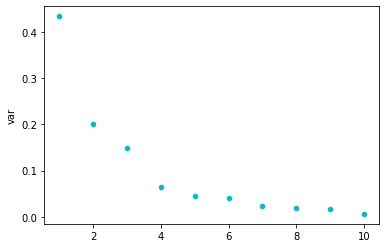

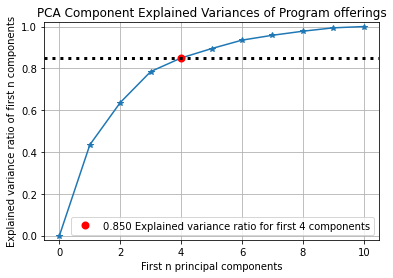

In [24]:
file_specific_pth = "images/STAND_TRAN/REDUC/PCA/"
ddrp_lst = ['GRAD_DEBT_MDN'] #,'TUITIONFEE_IN_exp', 'TUITIONFEE_IN_p3', 'TUITIONFEE_OUT_p3', 'MALE_DEBT_MDN_p3', 'TUITIONFEE_OUT_p2',"NOPELL_DEBT_N_exp", "AVGFACSAL_exp"]
mutual_info = mutual_info_classif(xtrain3.drop(ddrp_lst, axis = 1), y_train, random_state=rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain3.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain3.drop(ddrp_lst, axis = 1).columns[lst]
x_train3 = xtrain3[lst]
x_test3 = xtest3[lst]
x_valid3 = xvalid3[lst]

x_t3_lst = lst

%matplotlib inline
k = 50

xtrain_var = x_train3
xtest_var = x_test3
xvalid_var = x_valid3
print(xtrain_var.shape)

initial_feature_names = list(xtrain_var.columns)

pca = PCA(n_components = 10,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:2].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable = interest_variable.sort_values([1], ascending = False)
interest_variable

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


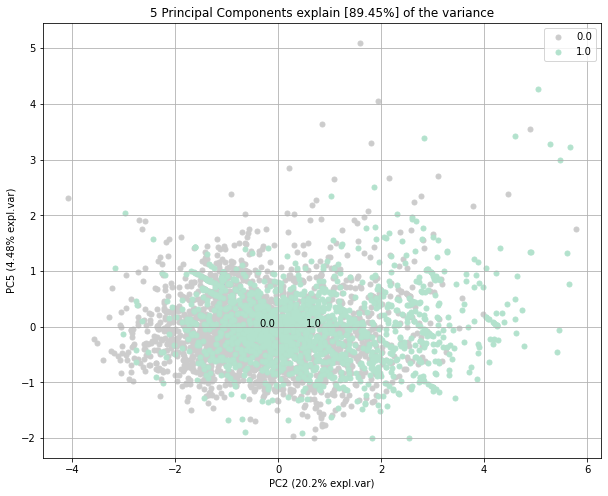

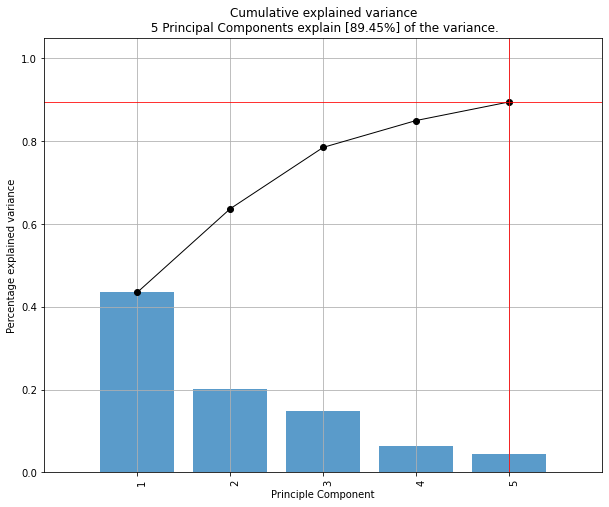

<Figure size 432x288 with 0 Axes>

In [25]:
from pca import pca
model = pca(n_components=5, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [1, 4])#np.arange(0,k,1)) 1 4    2  1     3 0
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=5) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

### Logistic Regression

#### Original dataset

###### All variables

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best Training Accuracy:  0.57
Best     Test Accuracy:  0.584
Best    Valid Accuracy:  0.554
Best      Training AUC:  0.5704
Best          Test AUC:  0.6116
Best         Valid AUC:  0.5844
Ratio of T / F 1.4038461538461537
Ratio of T / F 1.4038461538461537


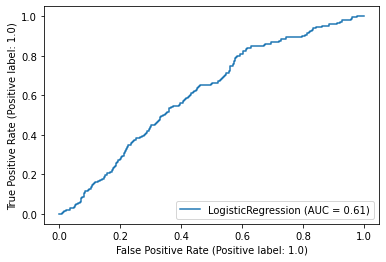

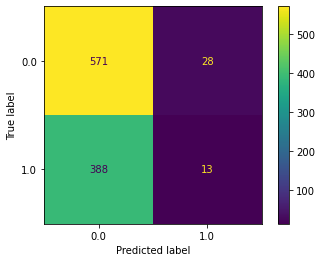

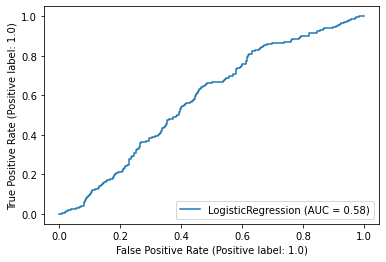

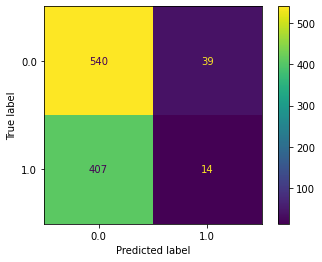

In [26]:
file_specific_pth = "images/ORIG/FULL/LogReg/"

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 10)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy



print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
print("Ratio of T / F", (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]))

print("Ratio of T / F", (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]))

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_test.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_test.png')

metrics.plot_roc_curve(logReg, xvalid_var, y_valid)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_valid.png')

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_valid.png')

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best Training Accuracy:  0.3929
Best     Test Accuracy:  0.383
Best    Valid Accuracy:  0.401
Best      Training AUC:  0.4286
Best          Test AUC:  0.4211
Best         Valid AUC:  0.4223


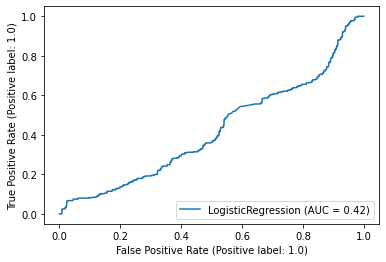

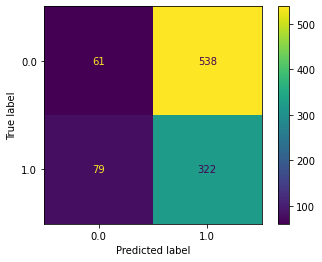

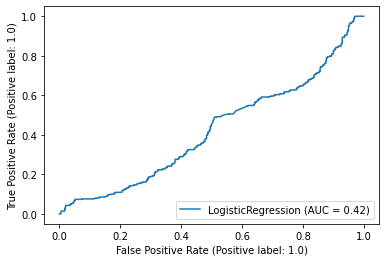

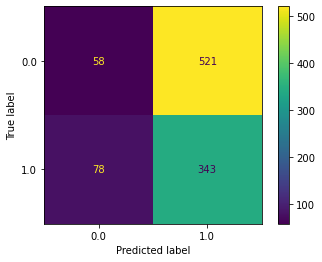

In [27]:
file_specific_pth = "images/ORIG/REDUC/LogReg/"

xtrain_var = x_train[x_t1_lst]
xtest_var = x_test[x_t1_lst]
xvalid_var = x_valid[x_t1_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.1, 
                            class_weight = "balanced",
                            max_iter = 50)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_test.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_test.png')

metrics.plot_roc_curve(logReg, xvalid_var, y_valid)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_valid.png')

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_valid.png')

#### Standardized dataset

###### All variables

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best Training Accuracy:  0.8801
Best     Test Accuracy:  0.867
Best    Valid Accuracy:  0.872
Best      Training AUC:  0.9533
Best          Test AUC:  0.944
Best         Valid AUC:  0.9532


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


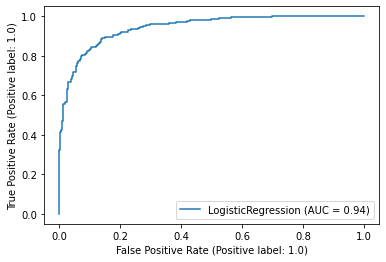

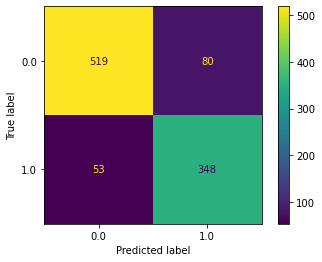

In [28]:
file_specific_pth = "images/STAND/FULL/LogReg/"

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.05, 
                            class_weight = "balanced",
                            max_iter = 500)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

###### Reduced to the 10 most independent

Best Training Accuracy:  0.8067
Best     Test Accuracy:  0.822
Best    Valid Accuracy:  0.813
Best      Training AUC:  0.8866
Best          Test AUC:  0.8973
Best         Valid AUC:  0.8842


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


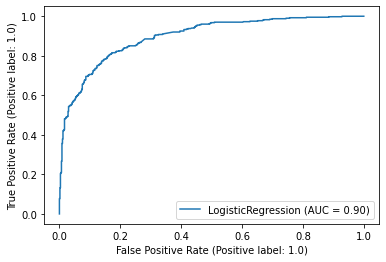

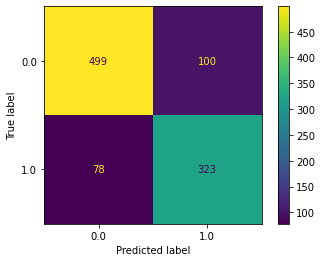

In [29]:
file_specific_pth = "images/STAND/REDUC/LogReg/"

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 50)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

#### Standardized-Transformed dataset

###### All variables

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best Training Accuracy:  0.8806
Best     Test Accuracy:  0.866
Best    Valid Accuracy:  0.874
Best      Training AUC:  0.9559
Best          Test AUC:  0.9459
Best         Valid AUC:  0.9547


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


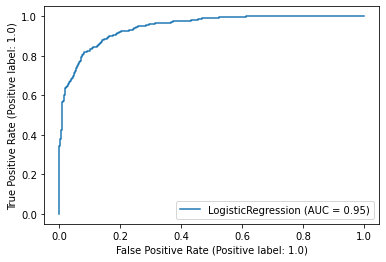

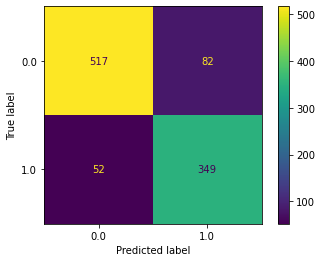

In [30]:
file_specific_pth = "images/STAND_TRAN/FULL/LogReg/"

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.1, 
                            class_weight = "balanced",
                            max_iter = 100)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

###### Reduced to the 10 most independent

Best Training Accuracy:  0.8054
Best     Test Accuracy:  0.83
Best    Valid Accuracy:  0.812
Best      Training AUC:  0.8897
Best          Test AUC:  0.9017
Best         Valid AUC:  0.8909


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


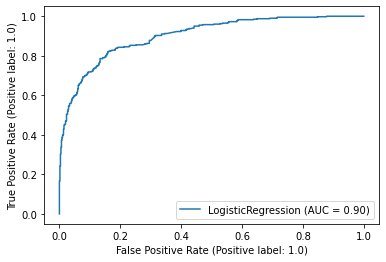

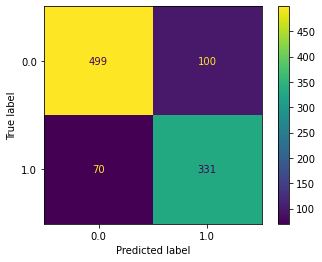

In [31]:
file_specific_pth = "images/STAND_TRAN/REDUC/LogReg/"

xtrain_var = x_train3[x_t3_lst]
xtest_var = x_test3[x_t3_lst]
xvalid_var = x_valid3[x_t3_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.005, 
                            class_weight = "balanced",
                            max_iter = 1)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

### Logistic Regression with PCA

#### Original dataset

###### All variables

Best Training Accuracy:  0.4906
Best     Test Accuracy:  0.499
Best    Valid Accuracy:  0.495
Best      Training AUC:  0.5913
Best          Test AUC:  0.6237
Best         Valid AUC:  0.5981


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


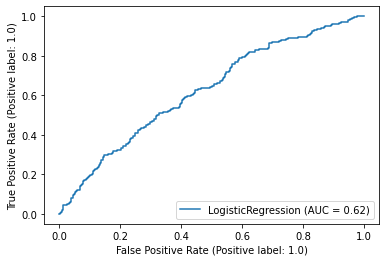

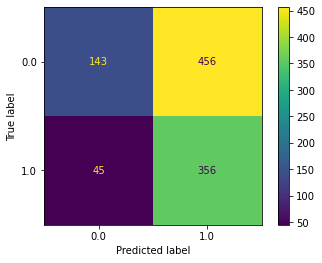

In [32]:
file_specific_pth = "images/ORIG/FULL/LogRegPCA/"

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 3)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 10)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best Training Accuracy:  0.5424
Best     Test Accuracy:  0.55
Best    Valid Accuracy:  0.527
Best      Training AUC:  0.4383
Best          Test AUC:  0.4276
Best         Valid AUC:  0.4298


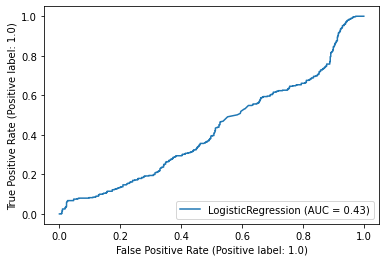

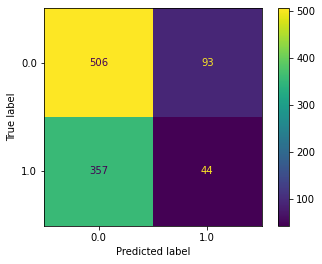

In [33]:
file_specific_pth = "images/ORIG/REDUC/LogRegPCA/"

xtrain_var = x_train[x_t1_lst]
xtest_var = x_test[x_t1_lst]
xvalid_var = x_valid[x_t1_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 8)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = .001, 
                            class_weight = "balanced",
                            max_iter = 100)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

#### Standardized dataset

###### All variables

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best Training Accuracy:  0.8912
Best     Test Accuracy:  0.867
Best    Valid Accuracy:  0.874
Best      Training AUC:  0.9614
Best          Test AUC:  0.9451
Best         Valid AUC:  0.9525


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


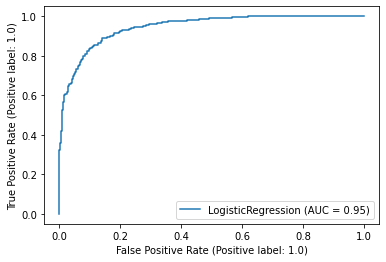

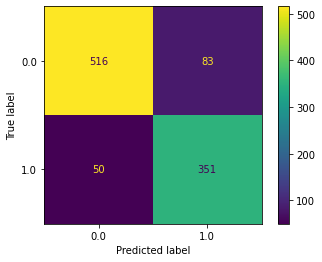

In [34]:
file_specific_pth = "images/STAND/FULL/LogRegPCA/"

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 1, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best Training Accuracy:  0.8059
Best     Test Accuracy:  0.822
Best    Valid Accuracy:  0.804
Best      Training AUC:  0.8842
Best          Test AUC:  0.8936
Best         Valid AUC:  0.8845


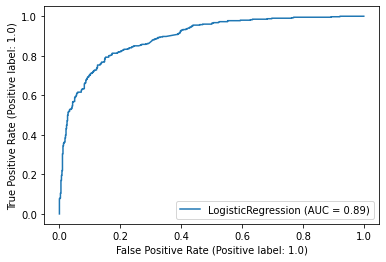

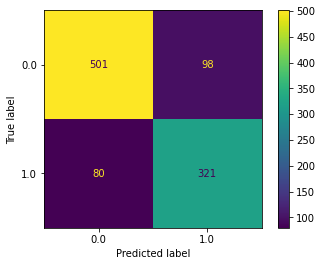

In [35]:
file_specific_pth = "images/STAND/REDUC/LogRegPCA/"

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

#### Standardized-Transformed dataset

###### All variables

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best Training Accuracy:  0.8817
Best     Test Accuracy:  0.872
Best    Valid Accuracy:  0.872
Best      Training AUC:  0.9568
Best          Test AUC:  0.9457
Best         Valid AUC:  0.9523


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


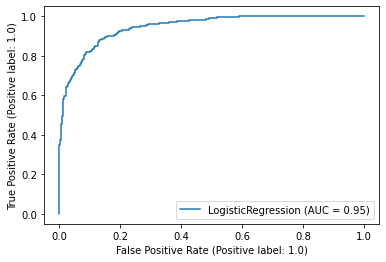

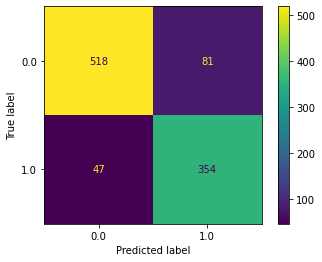

In [36]:
file_specific_pth = "images/STAND_TRAN/FULL/LogRegPCA/"

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

###### Reduced to the 10 most independent

Best Training Accuracy:  0.8061
Best     Test Accuracy:  0.828
Best    Valid Accuracy:  0.813
Best      Training AUC:  0.8904
Best          Test AUC:  0.9026
Best         Valid AUC:  0.8906


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


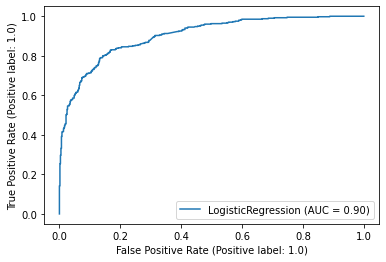

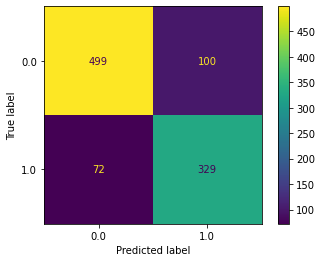

In [37]:
file_specific_pth = "images/STAND_TRAN/REDUC/LogRegPCA/"

xtrain_var = x_train3[x_t3_lst]
xtest_var = x_test3[x_t3_lst]
xvalid_var = x_valid3[x_t3_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

### KNN with PCA

#### Standardized dataset

###### All variables

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  1.0
Best     Test Accuracy:  0.833
Best    Valid Accuracy:  0.83
Best      Training AUC:  1.0
Best          Test AUC:  0.9138
Best         Valid AUC:  0.9117


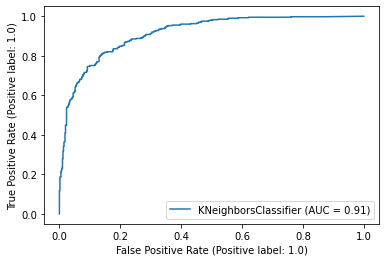

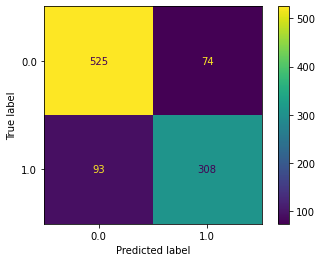

In [38]:
file_specific_pth = "images/STAND/FULL/KNN/"

x_train_var = xtrain2
x_test_var = xtest2
x_valid_var = xvalid2
train_y = pd.DataFrame(y_train)

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(random_state = rand_state)
pca.fit(x_train_var)

train_img = pd.DataFrame(pca.transform(x_train_var))
test_img = pd.DataFrame(pca.transform(x_test_var))
valid_img = pd.DataFrame(pca.transform(x_valid_var))
knc = KNeighborsClassifier(leaf_size=5,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  1.0
Best     Test Accuracy:  0.833
Best    Valid Accuracy:  0.831
Best      Training AUC:  1.0
Best          Test AUC:  0.9138
Best         Valid AUC:  0.9117


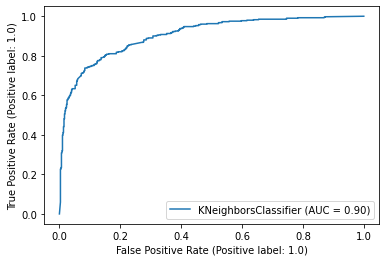

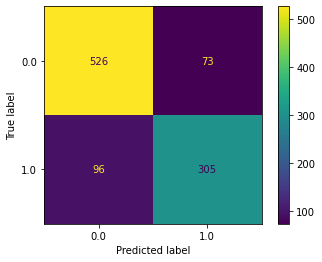

In [39]:
file_specific_pth = "images/STAND/REDUC/KNN/"

x_train_var = x_train2[x_t2_lst]
x_test_var = x_test2[x_t2_lst]
x_valid_var = x_valid2[x_t2_lst]

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 60,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

#### Standardized-Transformed dataset

###### All variables

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  1.0
Best     Test Accuracy:  0.834
Best    Valid Accuracy:  0.834
Best      Training AUC:  1.0
Best          Test AUC:  0.9138
Best         Valid AUC:  0.9117


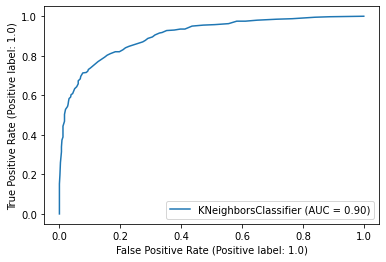

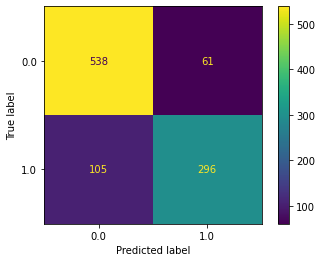

In [40]:
file_specific_pth = "images/STAND_TRAN/FULL/KNN/"

x_train_var = xtrain3
x_test_var = xtest3
x_valid_var = xvalid3

train_y = pd.DataFrame(y_train.reshape(-1,))

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable = interest_variable.sort_values([1], ascending = False)

train_img = pd.DataFrame(pca.transform(xtrain_var), columns = ["PC{}".format(i) for i in range(10)])
test_img = pd.DataFrame(pca.transform(xtest_var), columns = ["PC{}".format(i) for i in range(10)])
valid_img = pd.DataFrame(pca.transform(xvalid_var), columns = ["PC{}".format(i) for i in range(10)])

knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 65,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

In [41]:
df = pd.DataFrame(y_valid, columns = ["actual"])

df["prediction"] = knc.predict(valid_img)
df["corrrectORnot"] = np.where(df["prediction"] != df["actual"], 
                        np.where(df["actual"] == 1, .66, .33), df["prediction"])



# figure(figsize=(9, 6), dpi=160)
class_names = ["Correctly classified Majority Pell", "Correctly classified Minority Pell", "Incorrectly classified Majority Pell", "Incorrectly classified Minority Pell"]
sns.scatterplot(x = xtrain["PCTFLOAN"], y = xtrain["AVGFACSAL"], hue = df["corrrectORnot"], palette=sns.color_palette("icefire", 4))
plt.legend(labels = class_names)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_scatter.png')

NameError: name 'figure' is not defined

100%|██████████| 1000/1000 [08:46<00:00,  1.90it/s]


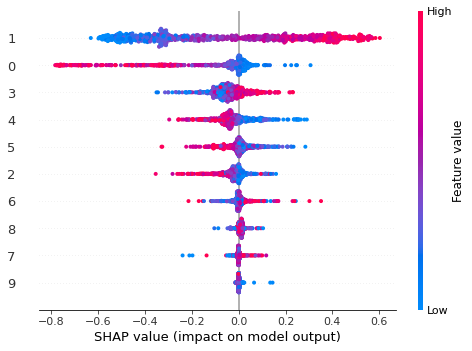

In [ ]:
knc_explainer = shap.KernelExplainer(knc.predict, shap.sample(test_img, 10))
knc_shap_values = knc_explainer.shap_values(test_img)
shap.summary_plot(knc_shap_values, test_img)

###### Reduced to the 10 most independent

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  1.0
Best     Test Accuracy:  0.833
Best    Valid Accuracy:  0.835
Best      Training AUC:  1.0
Best          Test AUC:  0.9138
Best         Valid AUC:  0.9162


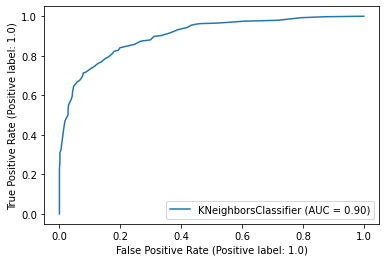

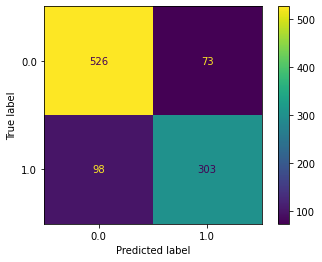

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/KNN/"

x_train_var = x_train3[x_t3_lst]
x_test_var = x_test3[x_t3_lst]
x_valid_var = x_valid3[x_t3_lst]

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

### XGBoost

#### Original dataset

###### All variables

[0]	validation_0-auc:0.85850	validation_1-auc:0.84691
[1]	validation_0-auc:0.86399	validation_1-auc:0.85544
[2]	validation_0-auc:0.88041	validation_1-auc:0.86649
[3]	validation_0-auc:0.89891	validation_1-auc:0.88373
[4]	validation_0-auc:0.90243	validation_1-auc:0.88763
[5]	validation_0-auc:0.91099	validation_1-auc:0.89761
[6]	validation_0-auc:0.90924	validation_1-auc:0.89683
[7]	validation_0-auc:0.91461	validation_1-auc:0.90214
[8]	validation_0-auc:0.91596	validation_1-auc:0.90294
[9]	validation_0-auc:0.92007	validation_1-auc:0.90680
[10]	validation_0-auc:0.92076	validation_1-auc:0.90932
[11]	validation_0-auc:0.92274	validation_1-auc:0.91321
[12]	validation_0-auc:0.92676	validation_1-auc:0.91580
[13]	validation_0-auc:0.92827	validation_1-auc:0.91724
[14]	validation_0-auc:0.92998	validation_1-auc:0.91954
[15]	validation_0-auc:0.93185	validation_1-auc:0.92180
[16]	validation_0-auc:0.93283	validation_1-auc:0.92244
[17]	validation_0-auc:0.93440	validation_1-auc:0.92571
[18]	validation_0-au

C:\Users\Nate\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[21]	validation_0-auc:0.93880	validation_1-auc:0.93000
[22]	validation_0-auc:0.93965	validation_1-auc:0.93032
[23]	validation_0-auc:0.93989	validation_1-auc:0.93086
[24]	validation_0-auc:0.94053	validation_1-auc:0.93198
[25]	validation_0-auc:0.94091	validation_1-auc:0.93278
[26]	validation_0-auc:0.94173	validation_1-auc:0.93366
[27]	validation_0-auc:0.94241	validation_1-auc:0.93481
[28]	validation_0-auc:0.94293	validation_1-auc:0.93513
[29]	validation_0-auc:0.94373	validation_1-auc:0.93581
[30]	validation_0-auc:0.94432	validation_1-auc:0.93680
[31]	validation_0-auc:0.94465	validation_1-auc:0.93671
[32]	validation_0-auc:0.94552	validation_1-auc:0.93724
[33]	validation_0-auc:0.94578	validation_1-auc:0.93761
[34]	validation_0-auc:0.94647	validation_1-auc:0.93794
[35]	validation_0-auc:0.94706	validation_1-auc:0.93859
[36]	validation_0-auc:0.94756	validation_1-auc:0.93887
[37]	validation_0-auc:0.94802	validation_1-auc:0.93918
[38]	validation_0-auc:0.94832	validation_1-auc:0.93983
[39]	valid

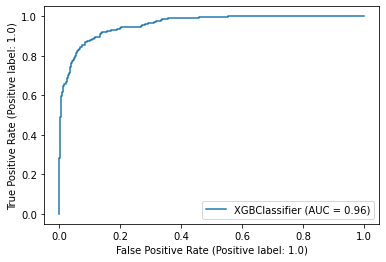

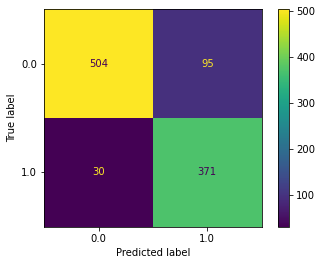

In [ ]:
file_specific_pth = "images/ORIG/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain)
test_x = pd.DataFrame(xtest)
valid_x = pd.DataFrame(xvalid)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                    max_depth = 2,
                    gamma = 0.5,
                    n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

###### Reduced to the 10 most independent

[0]	validation_0-auc:0.84697	validation_1-auc:0.84794
[1]	validation_0-auc:0.85197	validation_1-auc:0.85331
[2]	validation_0-auc:0.86565	validation_1-auc:0.85899
[3]	validation_0-auc:0.86776	validation_1-auc:0.86090
[4]	validation_0-auc:0.88435	validation_1-auc:0.88009
[5]	validation_0-auc:0.88525	validation_1-auc:0.88054
[6]	validation_0-auc:0.88943	validation_1-auc:0.88302
[7]	validation_0-auc:0.89332	validation_1-auc:0.88418
[8]	validation_0-auc:0.89332	validation_1-auc:0.88482
[9]	validation_0-auc:0.89618	validation_1-auc:0.88978
[10]	validation_0-auc:0.89666	validation_1-auc:0.88874
[11]	validation_0-auc:0.89734	validation_1-auc:0.88916
[12]	validation_0-auc:0.89981	validation_1-auc:0.89348
[13]	validation_0-auc:0.90136	validation_1-auc:0.89384
[14]	validation_0-auc:0.90363	validation_1-auc:0.89620
[15]	validation_0-auc:0.90788	validation_1-auc:0.89999
[16]	validation_0-auc:0.90775	validation_1-auc:0.90044
[17]	validation_0-auc:0.90862	validation_1-auc:0.90093
[18]	validation_0-au

C:\Users\Nate\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[75]	validation_0-auc:0.92670	validation_1-auc:0.91388
[76]	validation_0-auc:0.92677	validation_1-auc:0.91390
[77]	validation_0-auc:0.92681	validation_1-auc:0.91375
[78]	validation_0-auc:0.92688	validation_1-auc:0.91396
[79]	validation_0-auc:0.92714	validation_1-auc:0.91392
[80]	validation_0-auc:0.92734	validation_1-auc:0.91420
[81]	validation_0-auc:0.92742	validation_1-auc:0.91414
[82]	validation_0-auc:0.92772	validation_1-auc:0.91439
[83]	validation_0-auc:0.92788	validation_1-auc:0.91473
[84]	validation_0-auc:0.92795	validation_1-auc:0.91477
[85]	validation_0-auc:0.92824	validation_1-auc:0.91489
[86]	validation_0-auc:0.92843	validation_1-auc:0.91491
[87]	validation_0-auc:0.92842	validation_1-auc:0.91496
[88]	validation_0-auc:0.92862	validation_1-auc:0.91516
[89]	validation_0-auc:0.92873	validation_1-auc:0.91542
[90]	validation_0-auc:0.92887	validation_1-auc:0.91557
[91]	validation_0-auc:0.92899	validation_1-auc:0.91557
[92]	validation_0-auc:0.92908	validation_1-auc:0.91534
[93]	valid

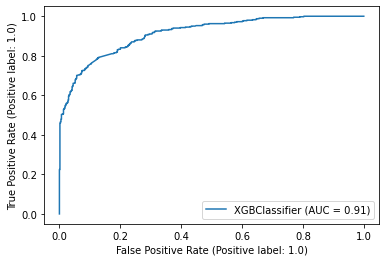

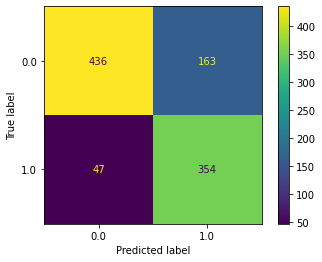

In [ ]:
file_specific_pth = "images/ORIG/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain[x_t1_lst])
test_x = pd.DataFrame(xtest[x_t1_lst])
valid_x = pd.DataFrame(xvalid[x_t1_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

#### Standardized dataset

###### All variables

[0]	validation_0-auc:0.85850	validation_1-auc:0.84691
[1]	validation_0-auc:0.86399	validation_1-auc:0.85544
[2]	validation_0-auc:0.88041	validation_1-auc:0.86649
[3]	validation_0-auc:0.89891	validation_1-auc:0.88373
[4]	validation_0-auc:0.90243	validation_1-auc:0.88763
[5]	validation_0-auc:0.91099	validation_1-auc:0.89761
[6]	validation_0-auc:0.90924	validation_1-auc:0.89683
[7]	validation_0-auc:0.91461	validation_1-auc:0.90214
[8]	validation_0-auc:0.91596	validation_1-auc:0.90294
[9]	validation_0-auc:0.92007	validation_1-auc:0.90680
[10]	validation_0-auc:0.92076	validation_1-auc:0.90932
[11]	validation_0-auc:0.92274	validation_1-auc:0.91321
[12]	validation_0-auc:0.92676	validation_1-auc:0.91580
[13]	validation_0-auc:0.92827	validation_1-auc:0.91724
[14]	validation_0-auc:0.92998	validation_1-auc:0.91954
[15]	validation_0-auc:0.93185	validation_1-auc:0.92180
[16]	validation_0-auc:0.93283	validation_1-auc:0.92244
[17]	validation_0-auc:0.93440	validation_1-auc:0.92571
[18]	validation_0-au

C:\Users\Nate\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[22]	validation_0-auc:0.93965	validation_1-auc:0.93032
[23]	validation_0-auc:0.93989	validation_1-auc:0.93086
[24]	validation_0-auc:0.94053	validation_1-auc:0.93198
[25]	validation_0-auc:0.94091	validation_1-auc:0.93278
[26]	validation_0-auc:0.94173	validation_1-auc:0.93366
[27]	validation_0-auc:0.94241	validation_1-auc:0.93481
[28]	validation_0-auc:0.94293	validation_1-auc:0.93513
[29]	validation_0-auc:0.94373	validation_1-auc:0.93581
[30]	validation_0-auc:0.94432	validation_1-auc:0.93680
[31]	validation_0-auc:0.94465	validation_1-auc:0.93671
[32]	validation_0-auc:0.94552	validation_1-auc:0.93724
[33]	validation_0-auc:0.94578	validation_1-auc:0.93761
[34]	validation_0-auc:0.94647	validation_1-auc:0.93794
[35]	validation_0-auc:0.94706	validation_1-auc:0.93859
[36]	validation_0-auc:0.94756	validation_1-auc:0.93887
[37]	validation_0-auc:0.94802	validation_1-auc:0.93918
[38]	validation_0-auc:0.94832	validation_1-auc:0.93983
[39]	validation_0-auc:0.94877	validation_1-auc:0.94040
[40]	valid

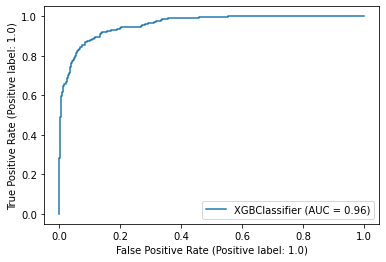

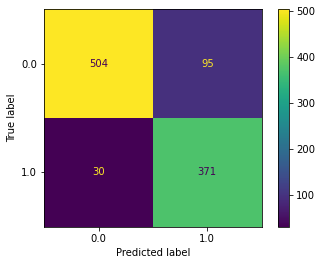

In [ ]:
file_specific_pth = "images/ORIG/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain2)
test_x = pd.DataFrame(xtest2)
valid_x = pd.DataFrame(xvalid2)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

###### Reduced to the 10 most independent

[0]	validation_0-auc:0.92439	validation_1-auc:0.87654
[1]	validation_0-auc:0.92978	validation_1-auc:0.88506
[2]	validation_0-auc:0.93185	validation_1-auc:0.88989
[3]	validation_0-auc:0.93385	validation_1-auc:0.89187
[4]	validation_0-auc:0.93777	validation_1-auc:0.89619
[5]	validation_0-auc:0.94075	validation_1-auc:0.89816
[6]	validation_0-auc:0.94236	validation_1-auc:0.89799
[7]	validation_0-auc:0.94397	validation_1-auc:0.89845
[8]	validation_0-auc:0.94457	validation_1-auc:0.89763
[9]	validation_0-auc:0.94634	validation_1-auc:0.89950
[10]	validation_0-auc:0.94695	validation_1-auc:0.89883
[11]	validation_0-auc:0.94826	validation_1-auc:0.90056
[12]	validation_0-auc:0.95049	validation_1-auc:0.90223
[13]	validation_0-auc:0.95193	validation_1-auc:0.90313
[14]	validation_0-auc:0.95262	validation_1-auc:0.90422
[15]	validation_0-auc:0.95356	validation_1-auc:0.90497
[16]	validation_0-auc:0.95517	validation_1-auc:0.90634
[17]	validation_0-auc:0.95605	validation_1-auc:0.90759
[18]	validation_0-au

C:\Users\Nate\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[50]	validation_0-auc:0.97294	validation_1-auc:0.91544
[51]	validation_0-auc:0.97314	validation_1-auc:0.91573
[52]	validation_0-auc:0.97341	validation_1-auc:0.91539
[53]	validation_0-auc:0.97364	validation_1-auc:0.91556
[54]	validation_0-auc:0.97418	validation_1-auc:0.91556
[55]	validation_0-auc:0.97476	validation_1-auc:0.91584
[56]	validation_0-auc:0.97494	validation_1-auc:0.91587
[57]	validation_0-auc:0.97521	validation_1-auc:0.91579
[58]	validation_0-auc:0.97541	validation_1-auc:0.91596
[59]	validation_0-auc:0.97557	validation_1-auc:0.91585
[60]	validation_0-auc:0.97588	validation_1-auc:0.91565
[61]	validation_0-auc:0.97604	validation_1-auc:0.91573
[62]	validation_0-auc:0.97657	validation_1-auc:0.91585
[63]	validation_0-auc:0.97694	validation_1-auc:0.91590
[64]	validation_0-auc:0.97713	validation_1-auc:0.91593
[65]	validation_0-auc:0.97730	validation_1-auc:0.91586
[66]	validation_0-auc:0.97760	validation_1-auc:0.91602
[67]	validation_0-auc:0.97784	validation_1-auc:0.91607
[68]	valid

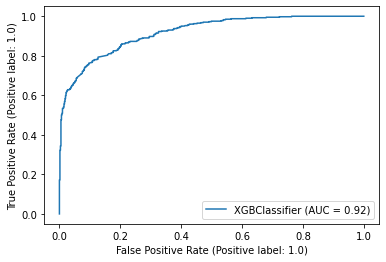

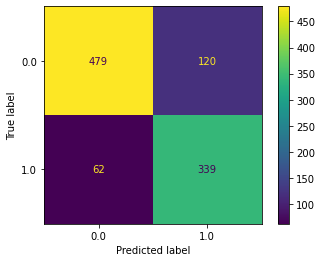

In [ ]:
file_specific_pth = "images/STAND/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train2[x_t2_lst])
test_x = pd.DataFrame(x_test2[x_t2_lst])
valid_x = pd.DataFrame(x_valid2[x_t2_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 6,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

#### Standardized-Transformed dataset

###### All variables

[0]	validation_0-auc:0.85850	validation_1-auc:0.84691
[1]	validation_0-auc:0.86399	validation_1-auc:0.85544
[2]	validation_0-auc:0.88041	validation_1-auc:0.86649
[3]	validation_0-auc:0.89891	validation_1-auc:0.88373
[4]	validation_0-auc:0.90243	validation_1-auc:0.88763
[5]	validation_0-auc:0.91099	validation_1-auc:0.89761
[6]	validation_0-auc:0.90924	validation_1-auc:0.89683
[7]	validation_0-auc:0.91461	validation_1-auc:0.90214
[8]	validation_0-auc:0.91596	validation_1-auc:0.90294
[9]	validation_0-auc:0.92007	validation_1-auc:0.90680
[10]	validation_0-auc:0.92076	validation_1-auc:0.90932
[11]	validation_0-auc:0.92274	validation_1-auc:0.91321
[12]	validation_0-auc:0.92676	validation_1-auc:0.91580
[13]	validation_0-auc:0.92827	validation_1-auc:0.91724
[14]	validation_0-auc:0.92998	validation_1-auc:0.91954
[15]	validation_0-auc:0.93185	validation_1-auc:0.92180
[16]	validation_0-auc:0.93283	validation_1-auc:0.92244


C:\Users\Nate\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[17]	validation_0-auc:0.93440	validation_1-auc:0.92571
[18]	validation_0-auc:0.93596	validation_1-auc:0.92706
[19]	validation_0-auc:0.93645	validation_1-auc:0.92770
[20]	validation_0-auc:0.93777	validation_1-auc:0.92854
[21]	validation_0-auc:0.93880	validation_1-auc:0.93000
[22]	validation_0-auc:0.93965	validation_1-auc:0.93032
[23]	validation_0-auc:0.93989	validation_1-auc:0.93086
[24]	validation_0-auc:0.94053	validation_1-auc:0.93198
[25]	validation_0-auc:0.94091	validation_1-auc:0.93278
[26]	validation_0-auc:0.94173	validation_1-auc:0.93366
[27]	validation_0-auc:0.94241	validation_1-auc:0.93481
[28]	validation_0-auc:0.94293	validation_1-auc:0.93513
[29]	validation_0-auc:0.94373	validation_1-auc:0.93581
[30]	validation_0-auc:0.94432	validation_1-auc:0.93680
[31]	validation_0-auc:0.94465	validation_1-auc:0.93671
[32]	validation_0-auc:0.94552	validation_1-auc:0.93724
[33]	validation_0-auc:0.94578	validation_1-auc:0.93761
[34]	validation_0-auc:0.94647	validation_1-auc:0.93794
[35]	valid

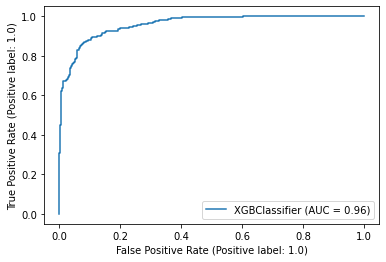

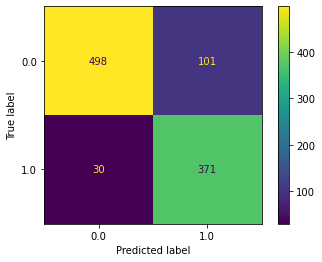

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain3)
test_x = pd.DataFrame(xtest3)
valid_x = pd.DataFrame(xvalid3)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

###### Reduced to the 10 most independent

[0]	validation_0-auc:0.89757	validation_1-auc:0.87066
[1]	validation_0-auc:0.92155	validation_1-auc:0.89873
[2]	validation_0-auc:0.92872	validation_1-auc:0.90309
[3]	validation_0-auc:0.93388	validation_1-auc:0.90415
[4]	validation_0-auc:0.93858	validation_1-auc:0.90839
[5]	validation_0-auc:0.94033	validation_1-auc:0.90822
[6]	validation_0-auc:0.94335	validation_1-auc:0.91038
[7]	validation_0-auc:0.94775	validation_1-auc:0.91431
[8]	validation_0-auc:0.95061	validation_1-auc:0.91743
[9]	validation_0-auc:0.95292	validation_1-auc:0.91894
[10]	validation_0-auc:0.95531	validation_1-auc:0.91766
[11]	validation_0-auc:0.95761	validation_1-auc:0.91914
[12]	validation_0-auc:0.95942	validation_1-auc:0.91985
[13]	validation_0-auc:0.96073	validation_1-auc:0.91953
[14]	validation_0-auc:0.96167	validation_1-auc:0.91872
[15]	validation_0-auc:0.96265	validation_1-auc:0.91806
[16]	validation_0-auc:0.96351	validation_1-auc:0.91730
[17]	validation_0-auc:0.96476	validation_1-auc:0.91797
[18]	validation_0-au

C:\Users\Nate\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[66]	validation_0-auc:0.99268	validation_1-auc:0.91568
[67]	validation_0-auc:0.99278	validation_1-auc:0.91588
[68]	validation_0-auc:0.99284	validation_1-auc:0.91576
[69]	validation_0-auc:0.99296	validation_1-auc:0.91579
[70]	validation_0-auc:0.99336	validation_1-auc:0.91535
[71]	validation_0-auc:0.99341	validation_1-auc:0.91505
[72]	validation_0-auc:0.99346	validation_1-auc:0.91497
[73]	validation_0-auc:0.99355	validation_1-auc:0.91521
[74]	validation_0-auc:0.99363	validation_1-auc:0.91514
[75]	validation_0-auc:0.99364	validation_1-auc:0.91513
[76]	validation_0-auc:0.99389	validation_1-auc:0.91485
[77]	validation_0-auc:0.99411	validation_1-auc:0.91497
[78]	validation_0-auc:0.99433	validation_1-auc:0.91418
[79]	validation_0-auc:0.99445	validation_1-auc:0.91399
[80]	validation_0-auc:0.99466	validation_1-auc:0.91383
[81]	validation_0-auc:0.99480	validation_1-auc:0.91431
[82]	validation_0-auc:0.99481	validation_1-auc:0.91444
[83]	validation_0-auc:0.99488	validation_1-auc:0.91411
[84]	valid

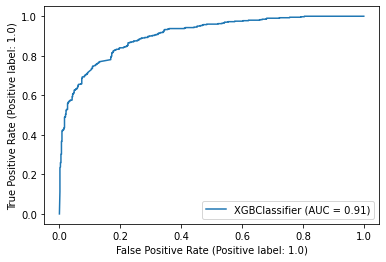

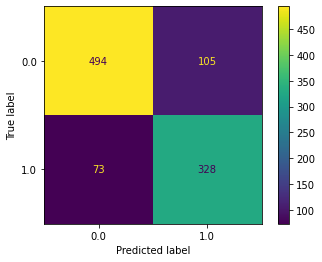

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train3[x_t3_lst])
test_x = pd.DataFrame(x_test3[x_t3_lst])
valid_x = pd.DataFrame(x_valid3[x_t3_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.70, 
                min_split_loss = 0,
                max_depth = 4,
                gamma = 0.01,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 1000)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

### Random Forest

#### Original dataset

###### All variables

C:\Users\Nate\AppData\Local\Temp/ipykernel_16916/4236569658.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  0.8631
Best     Test Accuracy:  0.843
Best    Valid Accuracy:  0.848
Best      Training AUC:  0.9501
Best          Test AUC:  0.9297
Best         Valid AUC:  0.9309


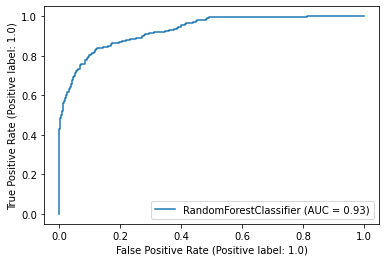

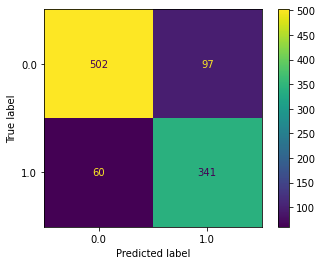

In [ ]:
file_specific_pth = "images/ORIG/FULL/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

###### Reduced to the 10 most independent

C:\Users\Nate\AppData\Local\Temp/ipykernel_16916/1946784161.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  0.858
Best     Test Accuracy:  0.84
Best    Valid Accuracy:  0.831
Best      Training AUC:  0.9371
Best          Test AUC:  0.9133
Best         Valid AUC:  0.9147


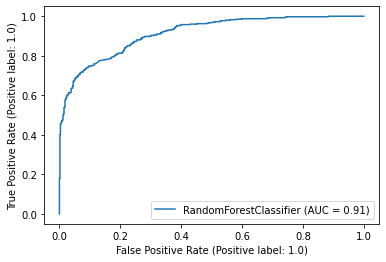

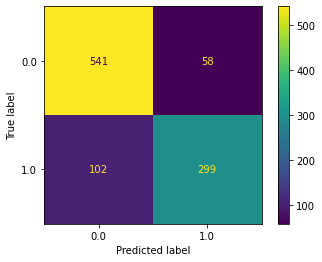

In [ ]:
file_specific_pth = "images/ORIG/REDUC/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain[x_t1_lst]
xtest_var = xtest[x_t1_lst]
xvalid_var = xvalid[x_t1_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

#### Standardized dataset

###### All variables

C:\Users\Nate\AppData\Local\Temp/ipykernel_16916/2230650230.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  0.8626
Best     Test Accuracy:  0.843
Best    Valid Accuracy:  0.847
Best      Training AUC:  0.9502
Best          Test AUC:  0.9296
Best         Valid AUC:  0.9309


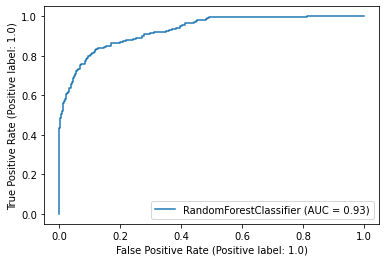

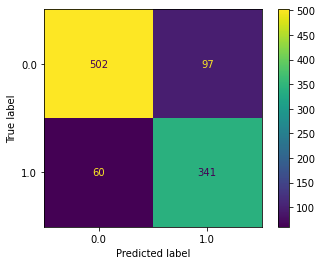

In [ ]:
file_specific_pth = "images/STAND/FULL/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

###### Reduced to the 10 most independent

C:\Users\Nate\AppData\Local\Temp/ipykernel_2852/2504269773.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  0.8598
Best     Test Accuracy:  0.845
Best    Valid Accuracy:  0.83
Best      Training AUC:  0.9365
Best          Test AUC:  0.914
Best         Valid AUC:  0.9135


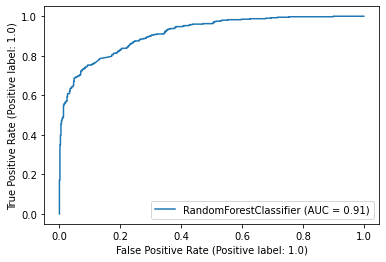

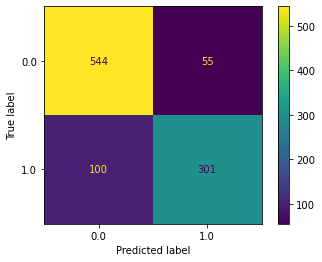

In [78]:
file_specific_pth = "images/STAND/REDUC/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

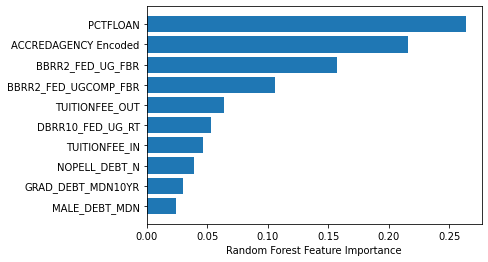

In [ ]:
sorted_idx = Random_forest.feature_importances_.argsort()
plt.barh(xtrain_var.columns.values[sorted_idx], Random_forest.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_featimport.png')

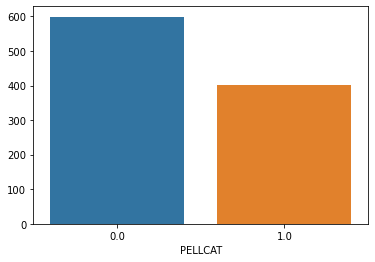

In [79]:
df = pd.DataFrame(y_test.reshape(-1,), columns = ["PELLCAT"])
df1 = pd.crosstab(df["PELLCAT"], columns = ["PELLCAT"])

sns.barplot(data = df1.T)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_testbarplot.png')

In [80]:
df1

col_0,PELLCAT
PELLCAT,
0.0,599
1.0,401


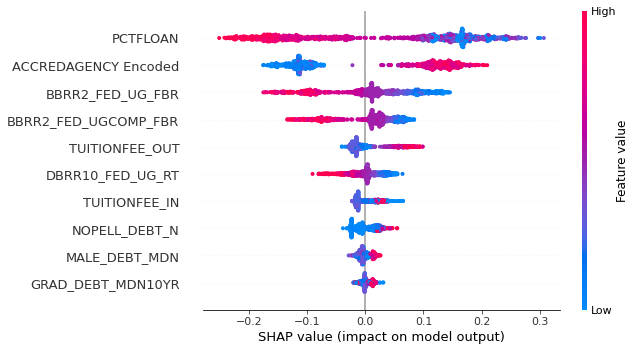

<Figure size 432x288 with 0 Axes>

In [ ]:
class_name = ["Majority Pell institution", "Minority Pell institution"]

explainer = shap.TreeExplainer(Random_forest)
shap_values = explainer.shap_values(xtest_var)
shap.summary_plot(shap_values[0], xtest_var, class_names = class_name, feature_names = xtest_var.columns.values)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_beeswarm.png')

#### Standardized-Transformed dataset

###### All variables

C:\Users\Nate\AppData\Local\Temp/ipykernel_16916/75319614.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  0.8629
Best     Test Accuracy:  0.845
Best    Valid Accuracy:  0.838
Best      Training AUC:  0.9504
Best          Test AUC:  0.9292
Best         Valid AUC:  0.9311


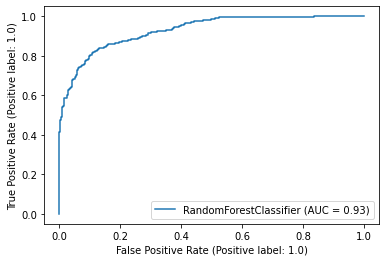

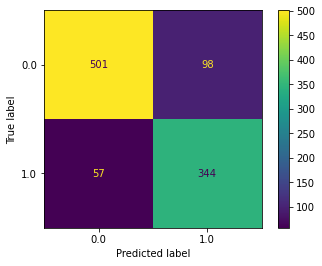

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

###### Reduced to the 10 most independent

C:\Users\Nate\AppData\Local\Temp/ipykernel_16916/1331520617.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  0.8636
Best     Test Accuracy:  0.843
Best    Valid Accuracy:  0.834
Best      Training AUC:  0.938
Best          Test AUC:  0.9153
Best         Valid AUC:  0.9146


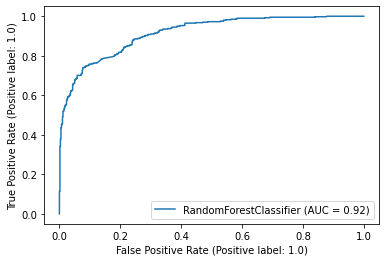

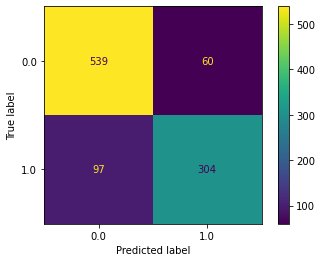

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain3[x_t3_lst]
xtest_var = xtest3[x_t3_lst]
xvalid_var = xvalid3[x_t3_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')